The French Electricity System relies heavily on nuclear power, which provides over 70% of the country's electricity[1], managed primarily by Électricité de France (EDF) through 56 reactors spread across 18 sites. These reactors serve as the backbone of the system, operating in both base-load and load-following modes. This is complemented by renewable energy sources, which include hydropower (the second-largest contributor), wind, and solar. Renewables currently account for about 25% of the electricity mix​[2].

Electricity generated at large plants (nuclear, hydropower dams, wind farms) is transmitted via a high-voltage grid managed by Réseau de Transport d'Électricité (RTE)[3]. This grid connects major generation sites to regional substations. From these substations, electricity is distributed to smaller local grids and ultimately to households and industries. Smart grid technologies and battery storage are being introduced to stabilize the variability of renewables and balance supply and demand​[4].

## Definitions

- Plants: Nuclear  generation sites.
- Substations: Intermediate nodes where electricity is stepped down and distributed.
- Demand Points: Cities or communities consuming electricity.

Sources:

[1] IEA: https://www.iea.org/countries/france/energy-mix#what-is-the-role-of-energy-transformation-in-france

[2] Wikipedia: https://en.wikipedia.org/wiki/Electricity_sector_in_France

[3] RTE: https://analysesetdonnees.rte-france.com/en

[4] AMARIS: https://amaris.com/insights/viewpoint/frances-energy-sector-in-2024/

# Scenario 1: LSTM

Using RTE's historical data on energy production since 1995 to train a simple LSTM model and use the prediction as input parameter for optimizing the supply of energy from Big plants (Nuclear), to Local substations and ultimately to cities.

## Setting the environment

In [1]:
!apt-get install coinor-cbc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  coinor-libcbc3 coinor-libcgl1 coinor-libclp1 coinor-libcoinutils3v5 coinor-libosi1v5
The following NEW packages will be installed:
  coinor-cbc coinor-libcbc3 coinor-libcgl1 coinor-libclp1 coinor-libcoinutils3v5 coinor-libosi1v5
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,908 kB of archives.
After this operation, 8,310 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 coinor-libcoinutils3v5 amd64 2.11.4+repack1-2 [465 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 coinor-libosi1v5 amd64 0.108.6+repack1-2 [275 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 coinor-libclp1 amd64 1.17.5+repack1-1 [937 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 coinor-libcgl1 amd64 0.60.3+repack1-3 [420 kB]
Get:5 http:/

In [3]:
# install library for optimization
!pip install pyomo

In [4]:
# update library
!pip install --upgrade pyomo scikit-learn scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 13.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


## Preprocessing Data

In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load and clean data
data = pd.read_csv('energy.csv', delimiter=";")  # Example file
data['Valeur (TWh)'] = pd.to_numeric(data['Valeur (TWh)'].str.replace(',', ''), errors='coerce')
data = data[data['Filière'] == 'Production totale'].reset_index() # filtering by final production
data = data.drop(columns=['index']) # supprim extra index column
data_values = data['Valeur (TWh)'].values.reshape(-1, 1)
data['Valeur (TWh)'] = data['Valeur (TWh)'].fillna(method='ffill')  # Handle missing values
data = data[data['Valeur (TWh)'] > 2000] # removing unrealistic outliers (closer to 0)
values = data['Valeur (TWh)'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Prepare training and test data
def create_dataset(dataset, look_back=12):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 12
X, Y = create_dataset(scaled_values, look_back)

# Split into training and testing datasets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Reshape input for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

<ipython-input-5-e0fa063422e8>:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Valeur (TWh)'] = data['Valeur (TWh)'].fillna(method='ffill')  # Handle missing values


In [6]:
#print
data

,Date,Filière,Valeur (TWh),Nature
0,1995-01,Production totale,4832.0,Données Consolidées
1,1995-02,Production totale,3949.0,Données Consolidées
2,1995-03,Production totale,4441.0,Données Consolidées
4,1995-05,Production totale,3653.0,Données Consolidées
5,1995-06,Production totale,3527.0,Données Consolidées
...,...,...,...,...
353,2024-06,Production totale,3954.0,Données Consolidées
354,2024-07,Production totale,4145.0,Données Consolidées
355,2024-08,Production totale,3981.0,Données Consolidées
356,2024-09,Production totale,3955.0,Données Consolidées


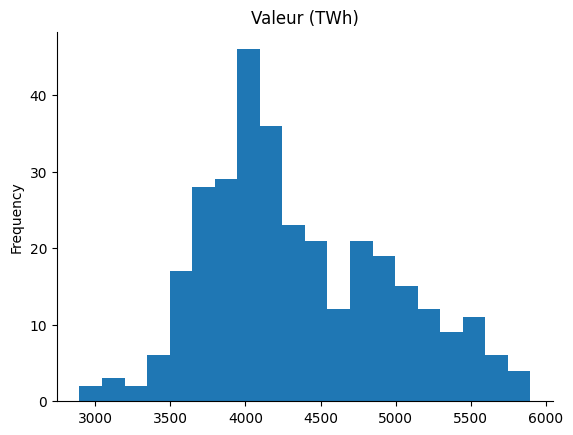

In [7]:
# see the distribution of the data
from matplotlib import pyplot as plt
data['Valeur (TWh)'].plot(kind='hist', bins=20, title='Valeur (TWh)')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Training the LSTM model

In [8]:
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import tensorflow as tf

# Set random seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),  # Layer 1
    Dropout(0.2),
    LSTM(50, return_sequences=True),  # Layer 2
    Dropout(0.2),
    LSTM(50, return_sequences=True),  # Layer 3
    Dropout(0.2),
    LSTM(50, return_sequences=True),  # Layer 4
    Dropout(0.2),
    LSTM(50),  # Layer 5
    Dropout(0.2),
    Dense(1)  # Output Layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(
    X_train, Y_train,
    epochs=50,  # Fewer epochs to avoid overfitting with added complexity
    batch_size=32,
    validation_data=(X_test, Y_test)
)

# Test the model
predictions = model.predict(X_test)
predicted_values = scaler.inverse_transform(predictions)
actual_values = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Calculate and print the MSE
mse = mean_squared_error(actual_values, predicted_values)
print(f"Mean Squared Error (MSE): {mse:.2f}")

# Example comparison
print("Example actual vs predicted values:")
for i in range(5):
    print(f"Actual: {actual_values[i][0]:.2f}, Predicted: {predicted_values[i][0]:.2f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 159ms/step - loss: 0.2187 - val_loss: 0.0473
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0490 - val_loss: 0.0428
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0379 - val_loss: 0.0458
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0373 - val_loss: 0.0481
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0350 - val_loss: 0.0454
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0327 - val_loss: 0.0481
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0339 - val_loss: 0.0458
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0280 - val_loss: 0.0458
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0295 - val_loss: 0.0477
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0283 - val_loss: 0.0464
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0249 - val_loss: 0.0518
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0251 - val_loss: 0.0551

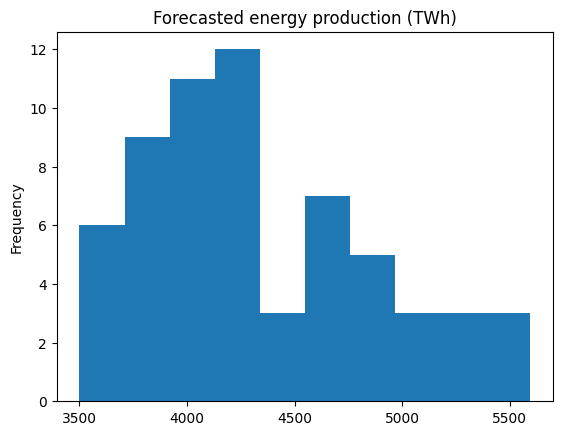

In [9]:
# Visualize predicted values
import matplotlib.pyplot as plt
plt.hist(predicted_values)
plt.ylabel("Frequency")
plt.title ("Forecasted energy production (TWh)")
plt.show()

## Objective function

The objective function aims to minimize the total cost
𝐶, which includes:

- The fixed costs of the main substations (A nuclear plant in this case).

- The fixed costs of the local substations.

- The variable costs associated with transporting volumes from main substations to local substations.

- The variable costs associated with transporting volumes from local substations to demand points (cities)

$\text{Minimize} \; C = \sum_{m \in \text{Main}} \text{FixedCost}_m + \sum_{s \in \text{Substation}} \text{FixedCost}_l + \sum_{m \in \text{Main}} \sum_{s \in \text{Substation}} \text{Cost}_{m,s} \cdot \text{Vol}_{m,s} + \sum_{s \in \text{Substation}} \sum_{d \in \text{Demand}} \text{Cost}_{s,d} \cdot \text{Vol}_{s,d}$


## Constraints

### Capacity constraints

Ensure that the volumes transported from main substations to local substations (Vol𝑚,𝑠) and from local substations to demand points (Vol𝑠,𝑑) do not exceed the respective capacities (Cap𝑚,𝑠 and Cap𝑠,𝑑)

$\text{Vol}_{m,s} \leq \text{Cap}_{m,s}, \; \forall m \in \text{Main}, \; s \in \text{Substation}$

<!-- $\text{Vol}_{\text{m}, s} \geq 0.7 \cdot \text{Cap}_{\text{m}, s}, \quad \forall m \in \text{Main},s \in \text{Substations}$ -->

$\text{Vol}_{s,d} \leq \text{Cap}_{s,d}, \; \forall s \in \text{Substation}, \; d \in \text{Demand}$



### Flow conservation

Ensure the flow conservation at each local substation so, the total volume received from main substations must equal the total volume sent to demand points.

$\sum_{m \in \text{Main}} \text{Vol}_{m,s} = \sum_{d \in \text{Demand}} \text{Vol}_{s,d}, \; \forall m \in \text{Main}, \; s \in \text{Substation}, \; d \in \text{Demand}$

<!-- $\sum_{\text{m}} \text{Vol}_{\text{m}, s} = \sum_{\text{d}} \text{Vol}_{s, \text{d}}$ -->

### Demand satisfaction

Ensure that the total volume delivered to demand points meets at least 90% of the forecasted capacity.

$\sum_{s \in \text{Substation}} \sum_{d \in \text{Demand}} \text{Vol}_{s,d} \geq 0.9 \cdot \text{ForecastedCapacity}$

### Non-negativity

Always positive values

$\text{Vol}_{m,s}, \; \text{Vol}_{s,d} \geq 0, \; \forall m \in \text{Main}, \; s \in \text{Substation}, \; d \in \text{Demand}$


Note: This example is provided for illustrative purposes only and does not reflect a real-world case scenario. However, the data used are the actual figures reported by RTE, but the capacity production used down below in the code, costs and the demand constraints are used as mere examples to demonstrate how optimization techniques can be leveraged to produce energy more efficiently, reduce costs, and simultaneously help the environment by minimizing the waste of unused resources.

In [10]:
import pyomo.environ as pyo

def optimize_energy_distribution(forecasted_capacity):
    """
    Optimizes energy distribution from plants to substations to cities
    to minimize cost while meeting demand.

    Args:
        forecasted_capacity (float): The forecasted energy demand.

    Returns:
        pyomo.opt.results.results_.SolverResults: The optimization results object.

    """
    # Parameters
    plants = ['Nuclear_Plant']
    substations = ['Substation_A', 'Substation_B']
    demand_points = ['City_1', 'City_2', 'City_3']

    # Simulating costs
    fixed_cost_plants = {'Nuclear_Plant': 1000}
    fixed_cost_substations = {'Substation_A': 400, 'Substation_B': 300}

    # Simulating transport costs from Nuclear to substations
    cost_plant_substation = {('Nuclear_Plant', 'Substation_A'): 0.2, ('Nuclear_Plant', 'Substation_B'): 0.3,
                            }
    cost_substation_city = {('Substation_A', 'City_1'): 0.3, ('Substation_A', 'City_2'): 0.4, ('Substation_A', 'City_3'): 0.5,
                            ('Substation_B', 'City_1'): 0.5, ('Substation_B', 'City_2'): 0.6, ('Substation_B', 'City_3'): 0.4}

    # Simulating Capacities
    capacity_plant_substation = {('Nuclear_Plant', 'Substation_A'): forecasted_capacity * 0.7,
                                ('Nuclear_Plant', 'Substation_B'): forecasted_capacity * 0.4,
                               }
    capacity_substation_city = {('Substation_A', 'City_1'): forecasted_capacity * 0.3,
                                ('Substation_A', 'City_2'): forecasted_capacity * 0.25,
                                ('Substation_A', 'City_3'): forecasted_capacity * 0.2,
                                ('Substation_B', 'City_1'): forecasted_capacity * 0.35,
                                ('Substation_B', 'City_2'): forecasted_capacity * 0.3,
                                ('Substation_B', 'City_3'): forecasted_capacity * 0.15}

    # Pyomo Model
    model = pyo.ConcreteModel()

    # Decision Variables
    model.vol_plant_substation = pyo.Var(plants, substations, domain=pyo.NonNegativeReals, initialize=0.1)
    model.vol_substation_city = pyo.Var(substations, demand_points, domain=pyo.NonNegativeReals, initialize=0.1)

    # Objective Function
    model.cost = pyo.Objective(
        expr=sum(fixed_cost_plants[p] for p in plants) +
            sum(fixed_cost_substations[s] for s in substations) +
            sum(cost_plant_substation[p, s] * model.vol_plant_substation[p, s] for p in plants for s in substations) +
            sum(cost_substation_city[s, d] * model.vol_substation_city[s, d] for s in substations for d in demand_points),
        sense=pyo.minimize
    )

    # Capacity Constraints

    def nuclear_capacity_constraint_rule(model, s):
        return model.vol_plant_substation['Nuclear_Plant', s] <= capacity_plant_substation['Nuclear_Plant', s]
    model.nuclear_capacity_limit = pyo.Constraint(substations, rule=nuclear_capacity_constraint_rule)


    def capacity_substation_city_rule(model, s, d):
        return model.vol_substation_city[s, d] <= capacity_substation_city[s, d]
    model.capacity_substation_city = pyo.Constraint(substations, demand_points, rule=capacity_substation_city_rule)

    # Demand Satisfaction
    model.demand_constraint = pyo.Constraint(
        expr=sum(model.vol_substation_city[s, d] for s in substations for d in demand_points) >= forecasted_capacity * 0.9
    )

    # Flow conservation constraint
    def flow_conservation_rule(model, s):
        return sum(model.vol_plant_substation[p, s] for p in plants) == sum(model.vol_substation_city[s, d] for d in demand_points)
    model.flow_conservation = pyo.Constraint(substations, rule=flow_conservation_rule)

    # Solve the model
    solver = pyo.SolverFactory('cbc')
    results = solver.solve(model)

    # Results
    print("\nSolver Status:", results.solver.status)
    print("Termination Condition:", results.solver.termination_condition)

    flow_data = {}  # Initialize an empty dictionary to store flow data

    if results.solver.termination_condition == pyo.TerminationCondition.optimal:
        flow_data['cost'] = pyo.value(model.cost)  # Store the optimal cost
        for p in plants:
            for s in substations:
                flow_data[(p, s)] = pyo.value(model.vol_plant_substation[p, s]) # Store plant-to-substation flow
        for s in substations:
            for d in demand_points:
                flow_data[(s, d)] = pyo.value(model.vol_substation_city[s, d]) # Store substation-to-city flow

        return flow_data  # Return the dictionary with flow data

    else:
        print("No optimal solution found.")
        return None  # Return None if no optimal solution is found



In [11]:
import pyomo.environ as pyo

# Forecasted Capacity (scaled for nationwide demand)
forecasted_capacity = predicted_values[:-1][0][0]
print(f"Using forecasted energy capacity: {forecasted_capacity:.2f} TWh")

result = optimize_energy_distribution(forecasted_capacity)
print(result)
lstm_alone_mean_result = result['cost']
lstm_alone_forecasted_capacity = forecasted_capacity

Using forecasted energy capacity: 5596.74 TWh

Solver Status: ok
Termination Condition: optimal
{'cost': 4778.208474999999, ('Nuclear_Plant', 'Substation_A'): 3917.7199, ('Nuclear_Plant', 'Substation_B'): 1119.3485, ('Substation_A', 'City_1'): 1679.0228, ('Substation_A', 'City_2'): 1399.1857, ('Substation_A', 'City_3'): 839.5114, ('Substation_B', 'City_1'): 279.83713, ('Substation_B', 'City_2'): 0.0, ('Substation_B', 'City_3'): 839.5114}


# Scenario 2: Bayesian adjusted LSTM

Using Bayesian approach to make more robust LSTM predictions.

For this, the posterior distribution is obtained by multiplying the likelihood of the observed data given the parameter values by the prior distribution.

I used a Kernel Density Estimator (KDE) to derive a distribution without making any assumpstion on the data (like Gaussian distribution). This is done to give room for flexibility and changes in the data, and also to account for the small skweness of the distribution of the predicted values. Due to the continous nature of KDE, the posterior has to be normalized to ensure it integrates to 1.

$
P(\theta \mid \text{data}) = \frac{P(\text{data} \mid \theta) \cdot P(\theta)}{\int P(\text{data} \mid \theta) \cdot P(\theta) \, d\theta}
$

Or in simplified terms:

$P(\theta \mid \text{data}) \propto P(\text{data} \mid \theta) \cdot P(\theta)$

So we will end up with an updated constraint of the opitmization problem for the demand that will look like:

$\sum \text{Vol}_{l,d} \geq D^{\text{posterior}}_d, \; \forall d$

where:

$D^{\text{posterior}}_d$ = Demand distribution derived from the Bayesian posterior



In [12]:
# Define prior using LSTM predictions
lstm_mean = np.mean(predicted_values)
lstm_std = np.std(predicted_values)
print(f"Prior Mean: {lstm_mean:.2f}, Prior Std Dev: {lstm_std:.2f}")


Prior Mean: 4330.84, Prior Std Dev: 521.22


In [13]:
# Observed data for posterior update
observed_data = data['Valeur (TWh)'].values[-len(Y_test):]  # Use the same test range as LSTM

# Compute posterior parameters
posterior_mean = (np.mean(observed_data) * len(observed_data) + lstm_mean) / (len(observed_data) + 1)
posterior_std = np.sqrt((lstm_std**2 + np.var(observed_data)) / (len(observed_data) + 1))
print(f"Posterior Mean: {posterior_mean:.2f}, Posterior Std Dev: {posterior_std:.2f}")


Posterior Mean: 4158.49, Posterior Std Dev: 103.97


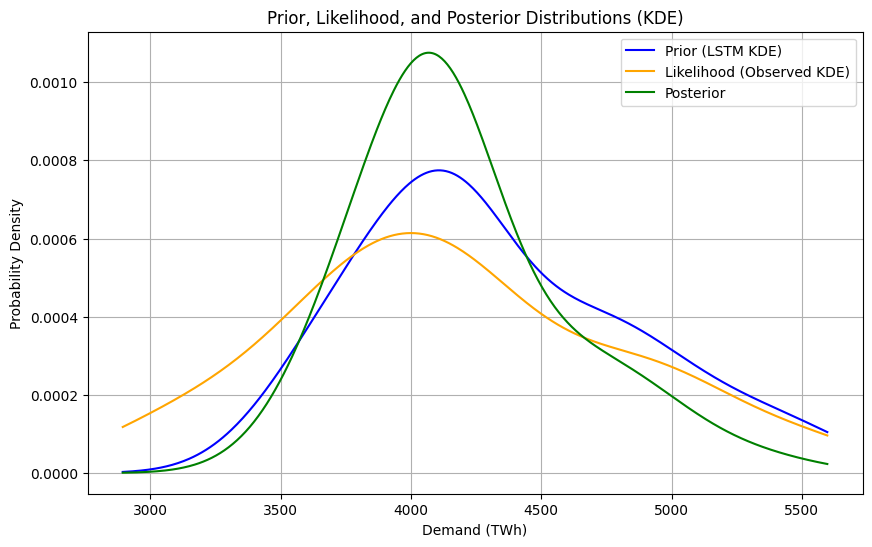

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde



# Perform KDE for prior (LSTM predictions)
kde_prior = gaussian_kde(predicted_values.flatten())  # Flatten predicted_values

# Perform KDE for likelihood (Observed data)
kde_likelihood = gaussian_kde(actual_values.flatten())

# Create a range of values for demand (spanning both datasets)
x = np.linspace(min(np.min(predicted_values), np.min(actual_values)) - 1,
                max(np.max(predicted_values), np.max(actual_values)) + 1, 500)

# Compute prior and likelihood KDE values
prior_pdf = kde_prior(x)
likelihood_pdf = kde_likelihood(x)

# Calculate unnormalized posterior (element-wise multiplication)
unnormalized_posterior = likelihood_pdf * prior_pdf

# Normalize the posterior to integrate to 1
posterior_pdf = unnormalized_posterior / np.trapz(unnormalized_posterior, x)

# Plot the distributions
plt.figure(figsize=(10, 6))
plt.plot(x, prior_pdf, label="Prior (LSTM KDE)", color='blue')
plt.plot(x, likelihood_pdf, label="Likelihood (Observed KDE)", color='orange')
plt.plot(x, posterior_pdf, label="Posterior", color='green')
plt.title("Prior, Likelihood, and Posterior Distributions (KDE)")
plt.xlabel("Demand (TWh)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid()
plt.show()


In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize a list to store the optimization results
optimization_results = []
forecasted_results = []

# Ensure the posterior integrates to 1
posterior_pdf = unnormalized_posterior / np.sum(unnormalized_posterior)
posterior_samples = np.random.choice(x, size=10, p=posterior_pdf/np.sum(posterior_pdf))
print(f"Posterior Samples: {posterior_samples}")


for sample in posterior_samples:
    forecasted_capacity = max(sample, 0)  # Ensure non-negative capacity
    print(f"\nUsing forecasted energy capacity: {forecasted_capacity:.2f} TWh")

    # Call the optimization function and store the result
    result = optimize_energy_distribution(forecasted_capacity)
    print(result)
    if result:  # Check if result is not None (optimization successful)
        optimization_results.append(result['cost'])  # Store the 'cost' value
    forecasted_results.append(forecasted_capacity)


# Calculate the mean of the optimization results
bayesian_mean_result = np.mean(optimization_results)
bayesian_forecasted_mean = np.mean(forecasted_results)

Posterior Samples: [4010.17433108 5023.40054425 4394.87519277 4226.90721091 3766.34984128
 3766.34984128 3576.70857144 4698.30122452 4232.3255329  4362.3652608 ]

Using forecasted energy capacity: 4010.17 TWh

Solver Status: ok
Termination Condition: optimal
{'cost': 3905.5958859999996, ('Nuclear_Plant', 'Substation_A'): 2807.122, ('Nuclear_Plant', 'Substation_B'): 802.03487, ('Substation_A', 'City_1'): 1203.0523, ('Substation_A', 'City_2'): 1002.5436, ('Substation_A', 'City_3'): 601.52615, ('Substation_B', 'City_1'): 200.50872, ('Substation_B', 'City_2'): 0.0, ('Substation_B', 'City_3'): 601.52615}

Using forecasted energy capacity: 5023.40 TWh

Solver Status: ok
Termination Condition: optimal
{'cost': 4462.870297, ('Nuclear_Plant', 'Substation_A'): 3516.3804, ('Nuclear_Plant', 'Substation_B'): 1004.6801, ('Substation_A', 'City_1'): 1507.0202, ('Substation_A', 'City_2'): 1255.8501, ('Substation_A', 'City_3'): 753.51008, ('Substation_B', 'City_1'): 251.17003, ('Substation_B', 'City_2')

# Scenario 3: Probabilistic Zonotope

What is a Zonotope?

A zonotope is a geometrical form that represents bounds in higher dimensions and allows for dependecies between varibales unlike interval arithmetic. This allows us to account for uncertainity establishing more robusts bounds.

The mathematical formulation is:

$Z = \alpha_0 + \sum_{i=1}^{n} \alpha_i \epsilon_i$

where:

$
\alpha_0$= The central value (center of the zonotope).

$\alpha_i$ = Generators that define the direction and magnitude of uncertainty.

$\epsilon_i \in [-1,1]$= Uncertainty terms scaled by the generators ($\alpha_i$)


Enhancing this, instead of using a fixed range of uncertainity, **probabilistic zonotopes** introduce a probabilistic distribution for $\epsilon_i$ derived from a probability density funciton (PDF) such as Gaussian or Uniform.

So, we defined it as:

$Z_i = \alpha_0 + \sum_{j=1}^{m} \alpha_j g_j$

where:


$
\alpha_0$ = predictions of the LSTM

$\alpha_j$ = variability of the observed data

$g_j \sim N(0, \sigma^2)$

In [16]:
import numpy as np

# LSTM predictions (central values)
lstm_predictions = predicted_values.flatten()

# Observed variability (used to define generator magnitudes)
observed_std = np.std(actual_values)

# Number of generators for probabilistic zonotope
num_generators = 5

# Define probabilistic zonotopes
probabilistic_zonotopes = []
for pred in lstm_predictions:
    # Central value
    alpha_0 = pred

    # Generators with random noise
    generators = np.random.normal(0, observed_std, num_generators)

    # Combine to form a probabilistic zonotope
    zonotope_samples = [
        alpha_0 + np.sum(generators * np.random.uniform(-1, 1, size=num_generators))  # Probabilistic epsilon
        for _ in range(10)  # Number of samples per zonotope
    ]
    probabilistic_zonotopes.append(zonotope_samples)

# Convert to a numpy array
probabilistic_zonotopes = np.array(probabilistic_zonotopes)
print("Probabilistic Zonotope Samples:", probabilistic_zonotopes)


Probabilistic Zonotope Samples: [[5576.84511035 5660.80456731 5224.25893798 5459.34734968 5527.3589141
  5205.43198036 5043.54646119 5328.46680719 6052.7312361  5812.94290871]
 [4737.53443703 4262.88700854 4349.38451229 4867.64449394 3777.54838355
  5290.03212245 4194.72251822 6534.57234454 5471.10944697 3654.48983055]
 [4583.05196537 5104.58587519 4631.01478139 4958.26376937 4390.17280021
  4572.45043825 5043.19618463 5310.01144494 4425.50779591 5607.73643835]
 [5383.60105768 4970.33030412 3414.36092168 5068.829078   4388.65056829
  5386.64947709 3617.07887462 4430.93754994 3832.62958014 2719.05454699]
 [3911.67898009 4710.38809692 4014.81355468 4604.24114131 4644.87299225
  3966.25957136 3733.59999759 4894.39367472 4418.10227238 4192.18322694]
 [4016.88985324 4097.40312339 3864.59114612 4178.63113889 4357.61302413
  3843.80389588 4027.49033718 3987.73053467 4030.61455963 3969.7003679 ]
 [3433.52556185 3940.79057738 4443.59286116 3247.09300966 3323.276469
  3964.8728267  4131.35552998

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize a list to store the optimization results (to compare methods)
optimization_results = []
forecasted_results = []


for zonotope_samples in probabilistic_zonotopes:
    # Use the mean of the zonotope samples as the central forecast
    forecasted_capacity = np.mean(zonotope_samples)
    print(f"\nUsing forecasted energy capacity: {forecasted_capacity:.2f} TWh")

    # Call the optimization function and store the result
    result = optimize_energy_distribution(forecasted_capacity)
    print(result)
    if result:  # Check if result is not None (optimization successful)
        optimization_results.append(result['cost'])  # Store the 'cost' value
    forecasted_results.append(forecasted_capacity)

# Calculate the mean of the optimization results
pz_mean_result = np.mean(optimization_results)
pz_forecasted_mean = np.mean(forecasted_results)


Using forecasted energy capacity: 5489.17 TWh

Solver Status: ok
Termination Condition: optimal
{'cost': 4719.045394, ('Nuclear_Plant', 'Substation_A'): 3842.4214, ('Nuclear_Plant', 'Substation_B'): 1097.8347, ('Substation_A', 'City_1'): 1646.752, ('Substation_A', 'City_2'): 1372.2934, ('Substation_A', 'City_3'): 823.37601, ('Substation_B', 'City_1'): 274.45867, ('Substation_B', 'City_2'): 0.0, ('Substation_B', 'City_3'): 823.37601}

Using forecasted energy capacity: 4713.99 TWh

Solver Status: ok
Termination Condition: optimal
{'cost': 4292.6958970000005, ('Nuclear_Plant', 'Substation_A'): 3299.7948, ('Nuclear_Plant', 'Substation_B'): 942.7985, ('Substation_A', 'City_1'): 1414.1978, ('Substation_A', 'City_2'): 1178.4981, ('Substation_A', 'City_3'): 707.09888, ('Substation_B', 'City_1'): 235.69963, ('Substation_B', 'City_2'): 0.0, ('Substation_B', 'City_3'): 707.09888}

Using forecasted energy capacity: 4862.60 TWh

Solver Status: ok
Termination Condition: optimal
{'cost': 4374.429522

# Scenario 4: Dempster-Shafer Theory

Dempster-Shafer Theory (DST) is used to model uncertainty and imprecise evidence by combining multiple sources of information to derive a degree of belief for a given hypothesis. It is based on:

- Mass Functions (𝑚): Assigns probabilities to subsets of possible outcomes within a range given by belief and plausibility functions.
- Belief Function (𝐵𝑒𝑙): Represents the total belief committed to a subset. It is basically the certainity of an outcome given some evidence (data)

- Plausibility Function (𝑃𝑙): Measures the maximum belief that could be assigned, considering the evidence. It represents the upper bound of the belief, capturing the highest degree of confidence one can assign to an outcome even in the presence of uncertainity.

The mathematical formulation to get the combined masses from the sources of evidence to compute the adjusted predictions is given by:

$m(A) = \frac{\sum_{B \cap C = A} m_1(B) \cdot m_2(C)}{1 - \sum_{B \cap C = \emptyset} m_1(B) \cdot m_2(C)}$

where:

$m(A)$ = new mass function (adjusted predictions)

$A$ = set of all possible outomes

$B,C$ = sets used for the combination process (LSTM predictions and observed data). They will contribute to the overall belief.

$B \cap C = A$ = pair of substes of B and C such that their intersection is A

$m(B), m(C)$ = beliefs (probabilities) of each subsets. Their product is the combined support for A

$B \cap C = \emptyset$ = empty intersection (evidence that doesn't overlap), this is the conflict evidence.

$1 - \sum_{B \cap C = \emptyset} m_1(B) \cdot m_2(C)$ = Normalizes the combined mass function by accounting for conflicting evidence given by the sum. Substracting 1 ensures the normalization.

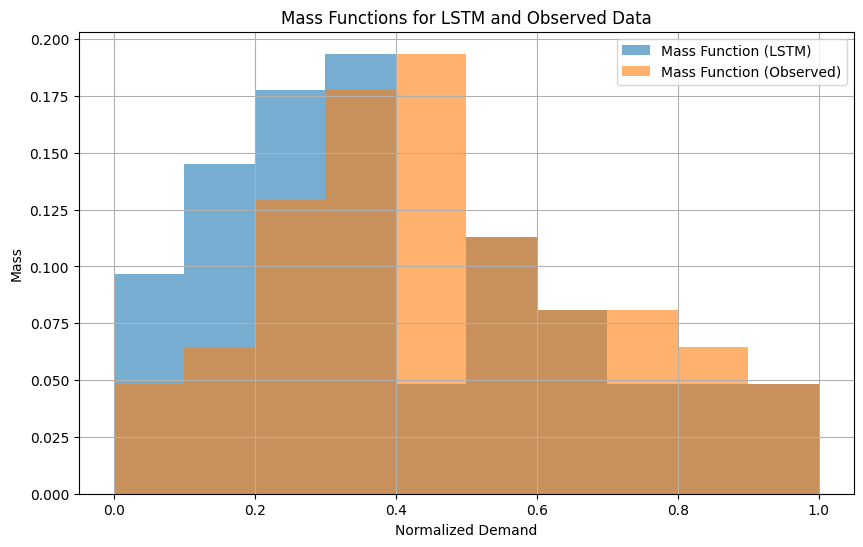

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# LSTM Predictions and Observed Data
lstm_predictions = predicted_values.flatten()
observed_data = actual_values.flatten()

# Normalize both datasets to [0, 1] for probability masses
lstm_normalized = (lstm_predictions - np.min(lstm_predictions)) / (np.max(lstm_predictions) - np.min(lstm_predictions))
observed_normalized = (observed_data - np.min(observed_data)) / (np.max(observed_data) - np.min(observed_data))

# Calculate Mass Functions
m1, bins = np.histogram(lstm_normalized, bins=10, range=(0, 1), density=True)
m2, _ = np.histogram(observed_normalized, bins=10, range=(0, 1), density=True)

# Normalize the mass functions
m1 /= np.sum(m1)
m2 /= np.sum(m2)

# Calculate bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2  # Average of consecutive bin edges

# Plot Mass Functions
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, m1, width=0.1, alpha=0.6, label='Mass Function (LSTM)')
plt.bar(bin_centers, m2, width=0.1, alpha=0.6, label='Mass Function (Observed)')
plt.title("Mass Functions for LSTM and Observed Data")
plt.xlabel("Normalized Demand")
plt.ylabel("Mass")
plt.legend()
plt.grid()
plt.show()


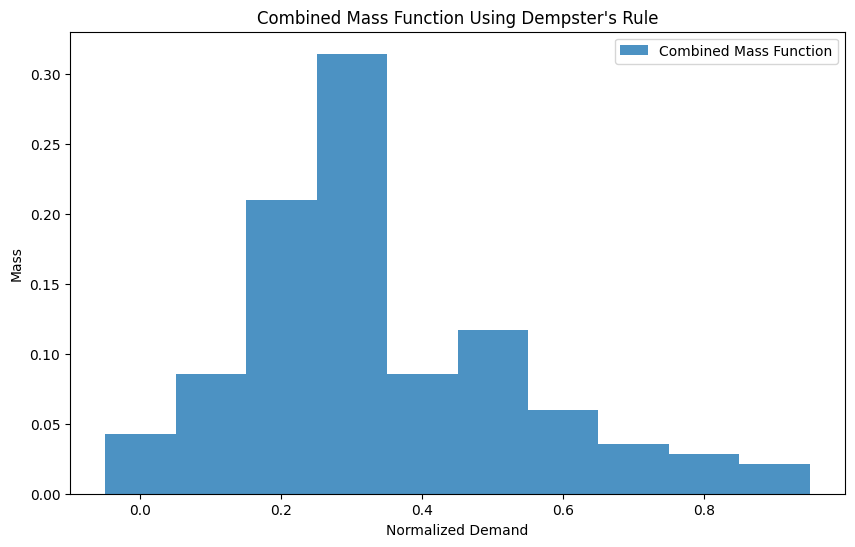

In [19]:
# Dempster's Rule of Combination
def combine_mass_functions(m1, m2):
    combined = np.zeros_like(m1)
    conflict = 0

    for i in range(len(m1)):
        for j in range(len(m2)):
            if i == j:  # Intersection exists
                combined[i] += m1[i] * m2[j]
            else:  # Conflict (disjoint subsets)
                conflict += m1[i] * m2[j]

    # Normalize by the conflict factor
    combined /= (1 - conflict)
    return combined

# Combine Evidence
combined_mass = combine_mass_functions(m1, m2)

# Plot Combined Mass Function
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], combined_mass, width=0.1, alpha=0.8, label='Combined Mass Function')
plt.title("Combined Mass Function Using Dempster's Rule")
plt.xlabel("Normalized Demand")
plt.ylabel("Mass")
plt.legend()
plt.show()


In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize a list to store the optimization results
optimization_results = []
forecasted_results = []

# Sampling forecasted capacities from the combined mass function
num_samples = 10
bin_centers = np.linspace(0, 1, len(combined_mass))  # Create bin centers
forecasted_capacities = np.random.choice(bin_centers, size=num_samples, p=combined_mass)
print(f"Forecasted Capacities: {forecasted_capacities}")

for capacity in forecasted_capacities:
    forecasted_capacity = capacity * (np.max(observed_data) - np.min(observed_data)) + np.min(observed_data)
    print(f"\nUsing forecasted energy capacity: {forecasted_capacity:.2f} TWh")

    # Call the optimization function and store the result (specifically the cost)
    result = optimize_energy_distribution(forecasted_capacity)
    print(result)
    if result:  # Check if result is not None (optimization successful)
        optimization_results.append(result['cost'])  # Store the 'cost' value
    forecasted_results.append(forecasted_capacity)

# Calculate the mean of the optimization results
dst_mean_result = np.mean(optimization_results)
dst_forecasted_mean = np.mean(forecasted_results)

Forecasted Capacities: [0.22222222 0.44444444 0.22222222 0.55555556 1.         0.
 0.66666667 0.33333333 0.88888889 0.33333333]

Using forecasted energy capacity: 3492.11 TWh

Solver Status: ok
Termination Condition: optimal
{'cost': 3620.661111, ('Nuclear_Plant', 'Substation_A'): 2444.4778, ('Nuclear_Plant', 'Substation_B'): 698.42222, ('Substation_A', 'City_1'): 1047.6333, ('Substation_A', 'City_2'): 873.02778, ('Substation_A', 'City_3'): 523.81667, ('Substation_B', 'City_1'): 174.60556, ('Substation_B', 'City_2'): 0.0, ('Substation_B', 'City_3'): 523.81667}

Using forecasted energy capacity: 4089.22 TWh

Solver Status: ok
Termination Condition: optimal
{'cost': 3949.072254, ('Nuclear_Plant', 'Substation_A'): 2862.4556, ('Nuclear_Plant', 'Substation_B'): 817.84444, ('Substation_A', 'City_1'): 1226.7667, ('Substation_A', 'City_2'): 1022.3056, ('Substation_A', 'City_3'): 613.38333, ('Substation_B', 'City_1'): 204.46111, ('Substation_B', 'City_2'): 0.0, ('Substation_B', 'City_3'): 613.3

## Scenario 4.1: Dempster-Shafer Theory updated with extra source of information (weather data)

This scenario explores the application of Dempster-Shafer Theory (DST) to enhance demand predictions by incorporating an additional source of information: weather data. Instead of directly integrating weather data into the LSTM predictions (which can be done to improve accuracy and account for extrnal factors and sources of information), it is introduced at this stage to demonstrate the following:

- Evaluation of LSTM Predictions: By not modifying the LSTM directly, this approach isolates the performance of the LSTM predictions, allowing to evaluate their baseline accuracy without external adjustments.

- Efficiency of Evidence Combination Models: DST provides a computationally efficient framework for combining multiple sources of evidence (such as LSTM predictions, observed data, and weather) and quantifying uncertainty, enabling for an interpretable model. This allows for flexible updates to predictions as new evidence becomes available, without retraining the original model.

- Incremental Evidence Integration: By integrating weather data at this stage, I explore how adding relevant but external information improves predictions beyond the capabilities of the LSTM alone, particularly in handling uncertainty and variability in energy demand.

The weather data I found, was structurally different from the production data given by RTE, which is monthly and globally for all France, while the weather data was found daily and by departement. So I took a rough approach by averaging and grouping by month-year. Again, this is by no means a real-case scenario, but rather an exercise to illustrate the capabilites of probabilistic models to handle uncertainity under the evidence of new data and how they can be leveraged for real-world scenarios.


source: https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm/table/?sort=date&q.timerange.date=date:%5B2018-10-31T23:00:00Z+TO+2024-10-31T22:59:59Z%5D

In [21]:
# Calculate the number of rows representing the last 20% of the energy data (test set)
# to match the dates with those of the weather data
num_rows = int(len(data) * 0.2)

# Get the last 20% of the DataFrame
last_20_percent = data.tail(num_rows)

# Display the result
last_20_percent

,Date,Filière,Valeur (TWh),Nature
286,2018-11,Production totale,4623.0,Données Consolidées
287,2018-12,Production totale,5328.0,Données Consolidées
288,2019-01,Production totale,5582.0,Données Consolidées
289,2019-02,Production totale,5011.0,Données Consolidées
290,2019-03,Production totale,5035.0,Données Consolidées
...,...,...,...,...
353,2024-06,Production totale,3954.0,Données Consolidées
354,2024-07,Production totale,4145.0,Données Consolidées
355,2024-08,Production totale,3981.0,Données Consolidées
356,2024-09,Production totale,3955.0,Données Consolidées


In [22]:
# Read weather data and store in a variable
weather_data =pd.read_csv('weather.csv',delimiter=";")

In [23]:
# Visualization of the data
weather_data.head()

,ID OMM station,Date,Pression au niveau mer,Variation de pression en 3 heures,Type de tendance barométrique,Direction du vent moyen 10 mn,Vitesse du vent moyen 10 mn,Température,Point de rosée,Humidité,...,Altitude,communes (name),communes (code),EPCI (name),EPCI (code),department (name),department (code),region (name),region (code),mois_de_l_annee
0,7558,2010-01-05T10:00:00+01:00,100280.0,-50.0,5.0,260.0,1.5,275.75,275.75,100.0,...,712,Millau,12145,CC de Millau Grands Causses,241200567.0,Aveyron,12,Occitanie,76.0,1
1,61976,2010-01-05T10:00:00+01:00,100990.0,NaN,NaN,NaN,NaN,305.45,299.05,69.0,...,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,7027,2010-01-05T13:00:00+01:00,100720.0,-190.0,8.0,200.0,3.6,273.65,271.75,87.0,...,67,Carpiquet,14137,CU Caen la Mer,200065597.0,Calvados,14,Normandie,28.0,1
3,7110,2010-01-05T13:00:00+01:00,100750.0,-230.0,8.0,210.0,4.1,276.95,272.55,73.0,...,94,Guipavas,29075,Brest Métropole,242900314.0,Finistère,29,Bretagne,53.0,1
4,7591,2010-01-05T13:00:00+01:00,NaN,NaN,NaN,NaN,NaN,274.45,269.05,67.0,...,871,Embrun,05046,CC Serre-Ponçon,200067742.0,Hautes-Alpes,05,Provence-Alpes-Côte d'Azur,93.0,1


In [24]:
# Exctart only the relevant columns and calculate average temperature by month-year

# Convert the 'Date' column to datetime if not already
weather_data['Date'] = pd.to_datetime(weather_data['Date'], format='%Y-%m-%dT%H:%M:%S%z', utc=True)

# Extract unique year-month combinations from last_20_percent
unique_year_months = last_20_percent['Date'].unique()

# Filter weather data based on unique year-months and the region
filtered_data = weather_data[
    (weather_data['Date'].dt.strftime('%Y-%m').isin(unique_year_months)) &
    (weather_data['region (name)'].str.contains("Provence-Alpes-Côte"))
]

# Create Year-Month column (if not already present) and calculate average temperature
filtered_data['YearMonth'] = filtered_data['Date'].dt.strftime('%Y-%m')
monthly_avg_temp_region = filtered_data.groupby(['region (name)', 'YearMonth'])['Température (°C)'].mean().reset_index()

# Display results
monthly_avg_temp_region

<ipython-input-24-0070ebfa63f7>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['YearMonth'] = filtered_data['Date'].dt.strftime('%Y-%m')


,region (name),YearMonth,Température (°C)
0,Provence-Alpes-Côte d'Azur,2018-11,11.947083
1,Provence-Alpes-Côte d'Azur,2018-12,8.266734
2,Provence-Alpes-Côte d'Azur,2019-01,5.338940
3,Provence-Alpes-Côte d'Azur,2019-02,8.555307
4,Provence-Alpes-Côte d'Azur,2019-03,11.219192
...,...,...,...
59,Provence-Alpes-Côte d'Azur,2024-06,20.413769
60,Provence-Alpes-Côte d'Azur,2024-07,24.561134
61,Provence-Alpes-Côte d'Azur,2024-08,25.664199
62,Provence-Alpes-Côte d'Azur,2024-09,18.817409


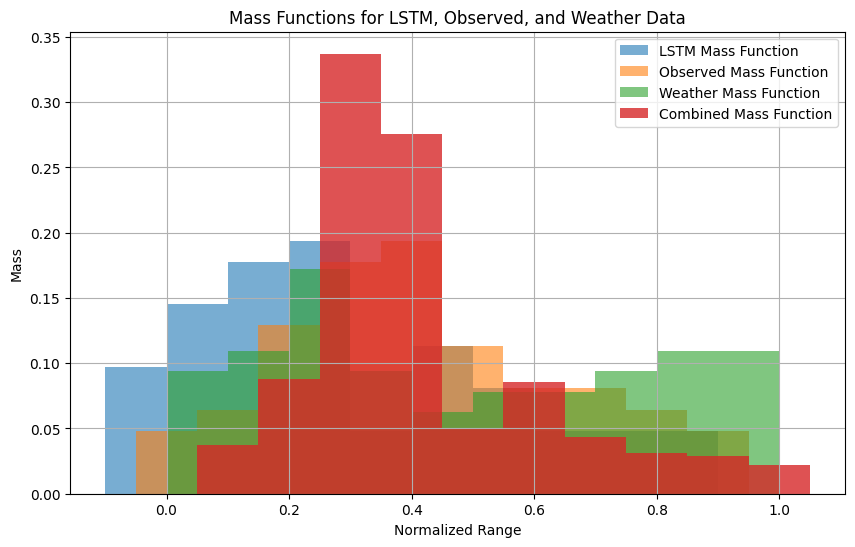

Forecasted Capacities: [0.55555556 0.11111111 0.22222222 0.11111111 0.88888889 0.55555556
 0.55555556 0.77777778 0.11111111 0.22222222]


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Renaming variable for easier use
weather_data = monthly_avg_temp_region

# Normalize Weather Data
weather_data['Température (°C)'] = (weather_data['Température (°C)'] - weather_data['Température (°C)'].min()) / (
    weather_data['Température (°C)'].max() - weather_data['Température (°C)'].min()
)
weather_normalized = weather_data[['Température (°C)']].mean(axis=1).values

# Define Mass Functions Using Histograms
def create_mass_function(data, bins=10, range=(0, 1)):
    mass, _ = np.histogram(data, bins=bins, range=range, density=True)
    mass_sum = np.sum(mass)
    if mass_sum > 0:
        return mass / mass_sum  # Normalize
    else:
        print("Warning: Mass function sum is zero. Returning zeros.")
        return np.zeros(bins)

m1 = create_mass_function(lstm_normalized)
m2 = create_mass_function(observed_normalized)
m_weather = create_mass_function(weather_normalized)

# Combine Mass Functions Using Dempster's Rule
def combine_three_mass_functions(m1, m2, m3):
    combined = np.zeros_like(m1)
    conflict = 0

    for i in range(len(m1)):
        for j in range(len(m2)):
            for k in range(len(m3)):
                if i == j == k:
                    combined[i] += m1[i] * m2[j] * m3[k]
                else:
                    conflict += m1[i] * m2[j] * m3[k]

    if 1 - conflict > 0:
        combined /= (1 - conflict)  # Normalize by 1 - conflict
    else:
        print("Warning: High conflict, resulting in invalid normalization.")
        combined.fill(0)  # Set to zeros if normalization fails

    return combined

combined_mass = combine_three_mass_functions(m1, m2, m_weather)

# Validate Combined Mass Function
if np.isnan(combined_mass).any() or np.sum(combined_mass) == 0:
    raise ValueError("Invalid combined mass function: Contains NaN or sum is zero.")

# Plot Mass Functions
bin_centers = np.linspace(0, 1, len(combined_mass))  # Create bin centers

plt.figure(figsize=(10, 6))
plt.bar(bins[:-1] - 0.05, m1, width=0.1, alpha=0.6, label='LSTM Mass Function')
plt.bar(bins[:-1], m2, width=0.1, alpha=0.6, label='Observed Mass Function')
plt.bar(bins[:-1]+ 0.05, m_weather, width=0.1, alpha=0.6, label='Weather Mass Function')
plt.bar(bins[:-1]+ 0.1, combined_mass, width=0.1, alpha=0.8, label='Combined Mass Function')
plt.title("Mass Functions for LSTM, Observed, and Weather Data")
plt.xlabel("Normalized Range")
plt.ylabel("Mass")
plt.legend()
plt.grid()
plt.show()

# Generate Forecasted Capacities
forecasted_capacities = np.random.choice(bin_centers, size=10, p=combined_mass)
print(f"Forecasted Capacities: {forecasted_capacities}")

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize a list to store the optimization results
optimization_results = []
forecasted_results = []

forecasted_capacities = np.random.choice(bin_centers, size=10, p=combined_mass)
print(f"Forecasted Capacities with Weather Data: {forecasted_capacities}")

for capacity in forecasted_capacities:
    forecasted_capacity = capacity * (np.max(observed_data) - np.min(observed_data)) + np.min(observed_data)
    print(f"\nUsing forecasted energy capacity: {forecasted_capacity:.2f} TWh")

    # Call the optimization function and store the result (specifically the cost)
    result = optimize_energy_distribution(forecasted_capacity)
    print(result)
    if result:  # Check if result is not None (optimization successful)
        optimization_results.append(result['cost'])  # Store the 'cost' value
    forecasted_results.append(forecasted_capacity)

# Calculate the mean of the optimization results
dst_weather_mean_result = np.mean(optimization_results)
dst_weather_forecasted_mean = np.mean(forecasted_results)

Forecasted Capacities with Weather Data: [0.11111111 0.22222222 0.22222222 0.33333333 0.22222222 0.11111111
 0.22222222 0.22222222 0.88888889 0.44444444]

Using forecasted energy capacity: 3193.56 TWh

Solver Status: ok
Termination Condition: optimal
{'cost': 3456.4555569999998, ('Nuclear_Plant', 'Substation_A'): 2235.4889, ('Nuclear_Plant', 'Substation_B'): 638.71111, ('Substation_A', 'City_1'): 958.06667, ('Substation_A', 'City_2'): 798.38889, ('Substation_A', 'City_3'): 479.03333, ('Substation_B', 'City_1'): 159.67778, ('Substation_B', 'City_2'): 0.0, ('Substation_B', 'City_3'): 479.03333}

Using forecasted energy capacity: 3492.11 TWh

Solver Status: ok
Termination Condition: optimal
{'cost': 3620.661111, ('Nuclear_Plant', 'Substation_A'): 2444.4778, ('Nuclear_Plant', 'Substation_B'): 698.42222, ('Substation_A', 'City_1'): 1047.6333, ('Substation_A', 'City_2'): 873.02778, ('Substation_A', 'City_3'): 523.81667, ('Substation_B', 'City_1'): 174.60556, ('Substation_B', 'City_2'): 0.0, 

# Scenario 5: Dempster-Shafer Zonotope

Building on the concepts of zonotopes, probabilistic zonotopes, and Dempster-Shafer Theory, the Dempster-Shafer Zonotope (DSZ) integrates these methodologies to model uncertainty in a geometric space.

Zonotope Basis: The geometric uncertainty space of a zonotope is defined by its center and generator vectors. In DSZ, this is extended by incorporating belief and plausibility from DST to set the lower (Belief) and upper (Plausibility) bounds of the zonotope based on observed evidence.

Between the bounds defined by belief and plausibility, a probability density function (PDF) is introduced, such as Gaussian or uniform. This PDF allows for a richer representation of uncertainty by modeling likelihoods within the defined geometric space, making the DSZ a probabilistic representation.

Finally, Individual DSZs are combined using Dempster’s Rule of Combination. This reflects the updated uncertainty space when incorporating new information, such as the predicitons from the LSTM, the observed data from energy production and the weather data.

Once the zonotopes are combined, belief and plausibility are recalculated over the resulting zonotope, reflecting the updated evidence. These bounds are determined using:


$
\begin{align*}
\text{Bel}(A_i) &= \sum_{j=1}^{i-1} m(A_j) + \frac{1}{2} m(A_i) \\
\text{Pl}(A_i) &= \sum_{j=1}^{i} m(A_j) + \frac{1}{2} m(A_{i+1})
\end{align*}
$

By doing this, DSZ not only models uncertainty more robustly but also dynamically update its bounds and uncertainty space as new evidence emerges, such as weather data, making it a versatile tool for demand prediction and optimization.

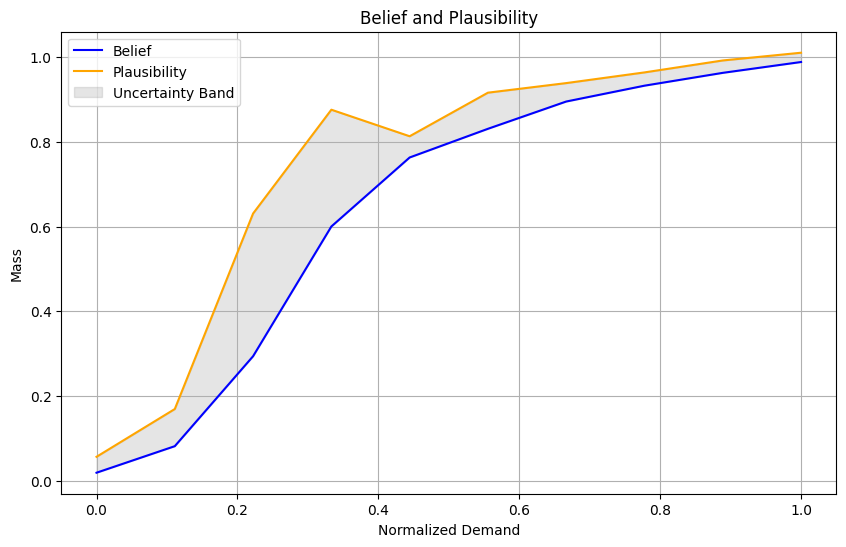

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Combined Mass Function
combined_mass = combine_three_mass_functions(m1, m2, m_weather)

# Validate Combined Mass Function
if np.isnan(combined_mass).any() or np.sum(combined_mass) == 0:
    raise ValueError("Invalid combined mass function: Contains NaN or sum is zero.")

# Calculate Belief and Plausibility
belief = np.cumsum(combined_mass) - combined_mass / 2
plausibility = np.cumsum(combined_mass) + combined_mass / 2

# Plot Belief and Plausibility
bin_centers = np.linspace(0, 1, len(combined_mass))  # Bin centers

plt.figure(figsize=(10, 6))
plt.plot(bin_centers, belief, label="Belief", color="blue")
plt.plot(bin_centers, plausibility, label="Plausibility", color="orange")
plt.fill_between(bin_centers, belief, plausibility, color="gray", alpha=0.2, label="Uncertainty Band")
plt.title("Belief and Plausibility")
plt.xlabel("Normalized Demand")
plt.ylabel("Mass")
plt.legend()
plt.grid()
plt.show()

# Construct DSZ
def construct_dsz(belief, plausibility, combined_mass):
    """Create a Dempster-Shafer Zonotope using a probabilistic zonotope with belief and plausibility as bounds."""
    center = np.mean(belief)  # Mean belief as the center
    bounds = plausibility - belief  # Uncertainty bounds
    probabilistic_part = combined_mass  # Probabilistic weights

    return {"center": center, "bounds": bounds, "probabilities": probabilistic_part}

dsz = construct_dsz(belief, plausibility, combined_mass)

# Sample from DSZ
def sample_from_dsz(dsz, num_samples=10):
    """Sample scenarios from the DSZ."""
    samples = []
    for _ in range(num_samples):
        epsilon = np.random.uniform(-1, 1, len(dsz["probabilities"]))  # [-1, 1] range
        sample = dsz["center"] + np.sum(dsz["bounds"] * epsilon * dsz["probabilities"])
        samples.append(sample)
    return np.array(samples)

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize a list to store the optimization results
optimization_results = []
forecasted_results = []

forecasted_capacities = sample_from_dsz(dsz, num_samples=10)
print(f"Forecasted Capacities from DSZ: {forecasted_capacities}")

for capacity in forecasted_capacities:
    forecasted_capacity = capacity * (np.max(observed_data) - np.min(observed_data)) + np.min(observed_data)
    print(f"\nUsing forecasted energy capacity: {forecasted_capacity:.2f} TWh")

    # Call the optimization function and store the result
    result = optimize_energy_distribution(forecasted_capacity)
    print(result)
    if result:  # Check if result is not None (optimization successful)
        optimization_results.append(result['cost'])  # Store the 'cost' value
    forecasted_results.append(forecasted_capacity)

# Calculate the mean of the optimization results
dsz_mean_result = np.mean(optimization_results)
dsz_forecasted_mean = np.mean(forecasted_results)


Forecasted Capacities from DSZ: [0.62638867 0.60795074 0.65032403 0.63749493 0.61644446 0.68932761
 0.6859211  0.56227704 0.61021435 0.63176789]

Using forecasted energy capacity: 4578.11 TWh

Solver Status: ok
Termination Condition: optimal
{'cost': 4217.958486, ('Nuclear_Plant', 'Substation_A'): 3204.6744, ('Nuclear_Plant', 'Substation_B'): 915.62127, ('Substation_A', 'City_1'): 1373.4319, ('Substation_A', 'City_2'): 1144.5266, ('Substation_A', 'City_3'): 686.71595, ('Substation_B', 'City_1'): 228.90532, ('Substation_B', 'City_2'): 0.0, ('Substation_B', 'City_3'): 686.71595}

Using forecasted energy capacity: 4528.56 TWh

Solver Status: ok
Termination Condition: optimal
{'cost': 4190.709994000001, ('Nuclear_Plant', 'Substation_A'): 3169.9945, ('Nuclear_Plant', 'Substation_B'): 905.71273, ('Substation_A', 'City_1'): 1358.5691, ('Substation_A', 'City_2'): 1132.1409, ('Substation_A', 'City_3'): 679.28455, ('Substation_B', 'City_1'): 226.42818, ('Substation_B', 'City_2'): 0.0, ('Substati

# Analysis of results and conclusions

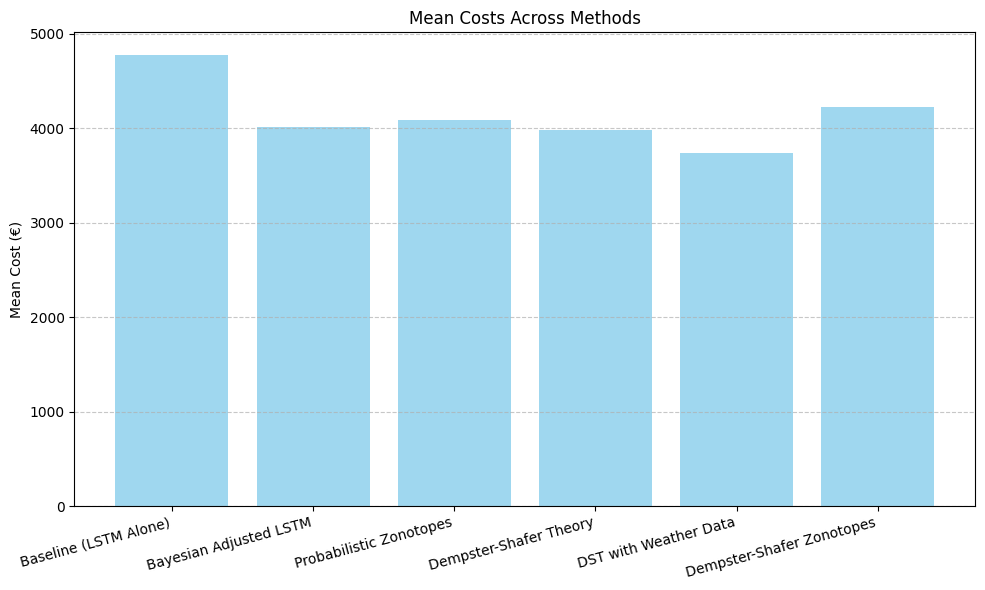

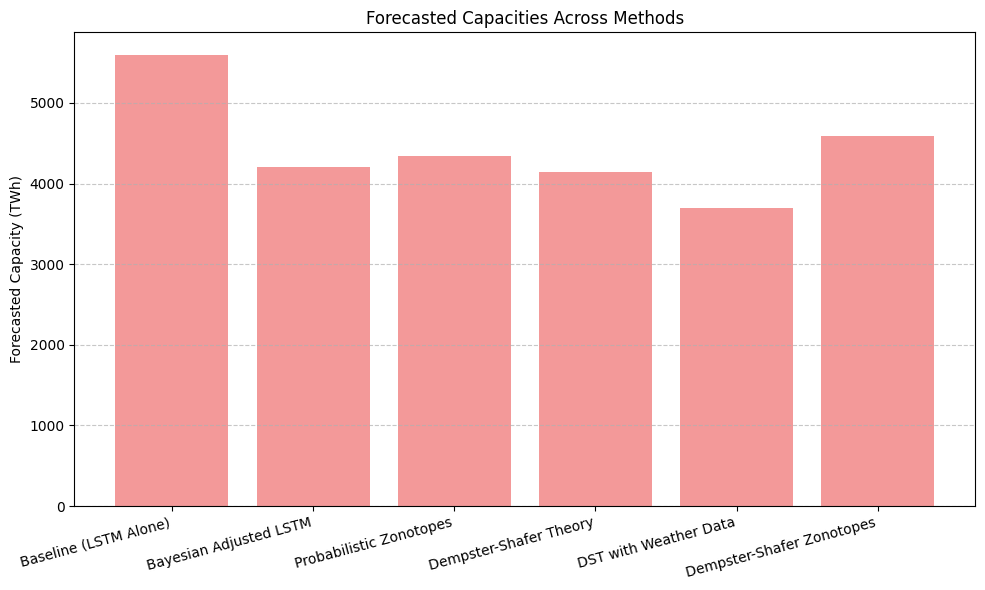

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Data for methods
methods = [
    "Baseline (LSTM Alone)",
    "Bayesian Adjusted LSTM",
    "Probabilistic Zonotopes",
    "Dempster-Shafer Theory",
    "DST with Weather Data",
    "Dempster-Shafer Zonotopes",
]

mean_costs = [lstm_alone_mean_result, bayesian_mean_result, pz_mean_result, dst_mean_result,dst_weather_mean_result, dsz_mean_result]
forecasted_capacities = [lstm_alone_forecasted_capacity,bayesian_forecasted_mean, pz_forecasted_mean, dst_forecasted_mean, dst_weather_forecasted_mean, dsz_forecasted_mean]

# Plot for Mean Costs
plt.figure(figsize=(10, 6))
plt.bar(methods, mean_costs, color='skyblue', alpha=0.8)
plt.title("Mean Costs Across Methods")
plt.ylabel("Mean Cost (€)")
plt.xticks(rotation=15, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot for Forecasted Capacities
plt.figure(figsize=(10, 6))
plt.bar(methods, forecasted_capacities, color='lightcoral', alpha=0.8)
plt.title("Forecasted Capacities Across Methods")
plt.ylabel("Forecasted Capacity (TWh)")
plt.xticks(rotation=15, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


As seen, the LSTM has the most conservative result, maybe because it captures just general patterns without explicitly accounting for variability, uncertainty, or external influencing factors.

Readjusting the predictions with bayesian methods, reduced the results which shows the ability to better calibrate predicitons and reduced overestimation facing the observed data, providing more realistic forecasts. However, it is important to notice that, even though the adjustments were made with the test set (data that the model hasn't never seen), it is still recommended to use an entirely new dataset from other sources to reinforced further the findings and ensure generalizability.

If compared to the probabilistic zonotopes, we see a little higher estimation than bayesian methods which could mean a balance between over and underfitting thanks to the way they handle uncertainity, suggesting also that they accounted for variability but retained some conservatism.

On the other hand, we see a more reduced results from DST, specially under new data such as weather, which was the lowest of all methods. This could be to several reasons such as the quality and over generalization of the treatment of the weather data, true correlations between both datasets or also showing a real readjustment of production accounting for seasonality such as summer compared to winter and that the use of energy is actually less than expected. However, these results highlight DST's capacity to dynamically adjust predictions in light of new evidence, considering the respective trade-offs.

Finally, DSZ displayed the most conservative results among the adjusted methods. This outcome reflects their robustness and flexibility under high uncertainty, particularly when integrating new evidence like weather. The results emphasize DSZ's resilience to both overestimation and underestimation, making it an effective approach for scenarios with significant uncertainty.

Overall, these methods showcase the benefits of integrating probabilistic techniques to refine machine learning predictions, particularly under uncertainty. Such approaches can deliver more realistic estimates of energy demand, avoiding overproduction and reducing inefficiencies. Furthermore, they provide better-calibrated inputs for optimization tasks. Future work could involve introducing additional and varied data to further improve the models and ensure robust performance.